In [1]:
# Os clusters determinados por este notebook são entendidos primariamente para fins de suporte à concessão de crédito.
# Os atributos selecionados são "dados cadastrais", de forma a permitir a classificação de clientes atuais e novos.
# 
# Etapas realizadas:
# 1- Limpeza do dataset, normalização e escolha de características;
# 2- Filtragem dos dados disponibilizados (faturamentoBruto >= 1.000,00 e <= 1.000.000,00 mensais);
# 3- Testados de 2 a 20 clusters com KMeans, sendo que a melhor separação foi de 7 clusters;
#    (considerando Elbow, Silhouette)
# 4- Um novo arquivo csv foi gerado para utilização no treinamento do classificador;
# 
# OBS: Uma projeção tridimensional dos clusters pode ser vista no fim do notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# carrega o dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/jblancoperez/fiap-desafio/main/solicitacoescredito.csv')

# print(datset.head(5))

In [3]:
# periodoDemonstrativoEmMeses -> converte valores nulos ou 0 em 1
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(np.nan, 1)
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(0, 1)

# faturamentoBruto -> converte valores nulos em 0 e divide pelo periodoDemonstrativoEmMeses
dataset['faturamentoBruto'] = dataset['faturamentoBruto'].replace(np.nan, 0)
dataset['faturamentoBruto'] = dataset['faturamentoBruto'] / dataset['periodoDemonstrativoEmMeses']

# margemBruta -> converte valores nulos em 0 e divide pelo periodoDemonstrativoEmMeses
dataset['margemBruta'] = dataset['margemBruta'].replace(np.nan, 0)
dataset['margemBruta'] = dataset['margemBruta'] / dataset['periodoDemonstrativoEmMeses']

In [4]:
# numero_solicitacao                                                    # irrelevante
# razaoSocial                                                           # irrelevante
# nomeFantasia                                                          # irrelevante
# cnpjSemTraco                                                          # irrelevante
# maiorAtraso                                                           # informação não existe na primeira compra
# margemBrutaAcumulada                                                  # informação não existe na primeira compra
# percentualProtestos = dataset['percentualProtestos']                  # ######## ver tratamento (abaixo)
# primeiraCompra                                                        # informação não existe na primeira compra
# prazoMedioRecebimentoVendas                                           # informação não existe na primeira compra
# titulosEmAberto = dataset['titulosEmAberto']                          # ok
# valorSolicitado                                                       # irrelevante
# status                                                                # informação não existe na primeira compra
# definicaoRisco = dataset['definicaoRisco']                            # ######## ver tratamento (abaixo)
# diferencaPercentualRisco                                              # irrelevante
# percentualRisco = dataset['percentualRisco']                          # ok
# dashboardCorrelacao                                                   # irrelevante
# valorAprovado                                                         # informação não existe na primeira compra
# dataAprovadoEmComite                                                  # informação não existe na primeira compra (e 8415 linhas com valor nulo)
# periodoBalanco                                                        # 4240 linhas com valor nulo
# ativoCirculante                                                       # 4240 linhas com valor nulo
# passivoCirculante                                                     # 4240 linhas com valor nulo
# totalAtivo                                                            # 4240 linhas com valor nulo
# totalPatrimonioLiquido                                                # 4240 linhas com valor nulo
# endividamento                                                         # 4240 linhas com valor nulo
# duplicatasAReceber                                                    # 4240 linhas com valor nulo
# estoque                                                               # 4240 linhas com valor nulo
faturamentoBruto = dataset['faturamentoBruto']                          # ######## ver tratamento (abaixo)
margemBruta = dataset['margemBruta']                                    # ######## ver tratamento (abaixo)
# periodoDemonstrativoEmMeses                                           # usado para normalizar o faturamentoBruto (acima)
# custos                                                                # irrelevante
# anoFundacao                                                           # irrelevante
# intervaloFundacao = dataset['intervaloFundacao']                      # ######## ver tratamento (abaixo)
# capitalSocial                                                         # irrelevante
restricoes = dataset['restricoes']                                      # ######## ver tratamento (abaixo)
# empresa_MeEppMei = dataset['empresa_MeEppMei']                        # ######## ver tratamento (abaixo)
# scorePontualidade                                                     # informação não existe na primeira compra
# limiteEmpresaAnaliseCredito = dataset['limiteEmpresaAnaliseCredito']  # ######## ver tratamento (abaixo)
# dataAprovadoNivelAnalista                                             # informação não existe na primeira compra

# monta o dataset que será trabalhado
dataset = pd.concat([
    faturamentoBruto,
    margemBruta,
    restricoes
], axis=1)

In [5]:
# faturamentoBruto -> remove valores nulos ou inferiores a 1.000,00 (outliers?)
dataset.dropna(subset=['faturamentoBruto'], inplace=True)
faturamentoBrutoIdx = dataset[(dataset['faturamentoBruto'] < 1000.0)].index
dataset.drop(faturamentoBrutoIdx, inplace=True)
# faturamentoBruto -> remove valores superiores a 500.000.000,00
faturamentoBrutoIdx = dataset[(dataset['faturamentoBruto'] > 1000000.0)].index
dataset.drop(faturamentoBrutoIdx, inplace=True)


# restricoes -> converte valores nulos em falso e transforma bool em int
dataset['restricoes'] = dataset['restricoes'].replace(np.nan, False)
dataset['restricoes'] = dataset['restricoes'].astype(int)

# remove valores duplicados (cada compra de uma empresa é uma foto)
dataset.drop_duplicates(inplace=True)

# indexa novamente o dataset para remover índices ainda em memória
dataset.reset_index(drop=True, inplace=True)

# print(dataset.head(5))
# print(dataset.count())

In [6]:
# normaliza os dados utilizando StandardScaler / MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset)

100%|██████████████████████████████████████████| 18/18 [00:13<00:00,  1.31it/s]


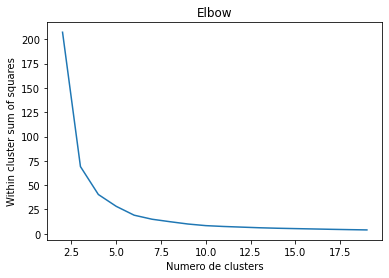

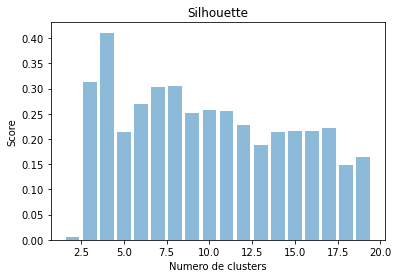

In [7]:
# busca o melhor valor de k para a clusterização, executando para k entre 2 e 20
inertias = []
scores = []
min_max_clusters = range(2, 20)
for i in tqdm(min_max_clusters):
    kmeans = KMeans(n_clusters=i, max_iter=100).fit(dataset_norm)
    inertias.append(kmeans.inertia_)
    scores.append(silhouette_score(dataset.values, kmeans.labels_))

# mostra Elbow
plt.figure(1)
plt.plot(min_max_clusters, inertias)
plt.title('Elbow')
plt.xlabel('Numero de clusters')
plt.ylabel('Within cluster sum of squares')
plt.show()

# mostra Silhouette
plt.figure(2)
plt.bar(min_max_clusters, scores, align='center', alpha=0.5)
plt.title('Silhouette')
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.show()

<IPython.core.display.Javascript object>


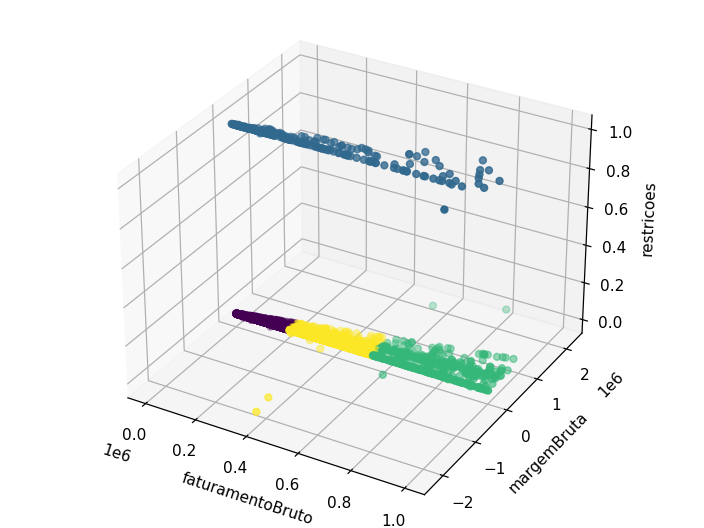

In [8]:
# executa kmeans com o melhor valor de k (encontrado acima)
bestKmeans = KMeans(n_clusters=4, max_iter=100).fit(dataset_norm)
labels = bestKmeans.labels_

# gera o dataset completo (adiciona a coluna 'cluster')
clusters = pd.concat([dataset, pd.DataFrame({'cluster': labels})], axis=1)

# print(clusters.head(5))

%matplotlib notebook
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = clusters["faturamentoBruto"]
sequence_containing_y_vals = clusters["margemBruta"]
sequence_containing_z_vals = clusters["restricoes"]

ax.set_xlabel('faturamentoBruto')
ax.set_ylabel('margemBruta')
ax.set_zlabel('restricoes')

p = ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c=clusters["cluster"])
pyplot.show()

In [9]:
# salva os dados clusterizados em csv
clusters.to_csv(path_or_buf='01.1-clusterizacao-kmeans.csv', sep=';', decimal=',')